<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/EfficientNet_b1_YouTube_clickbait_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [2]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.3 MB/s 


Get the latest EfficientNet weights, see- https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=00Inxf7v2Twf

In [ ]:
#!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b1.tar.gz
#!tar -xf noisy_student_efficientnet-b1.tar.gz

In [ ]:
#!python efficientnet_weight_update_util.py --model b1 --notop --ckpt noisy-student-efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5

#Imports

In [62]:
from __future__ import absolute_import, division, print_function
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API.

from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


from importlib import reload



#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')


import tf_dataset_helpers as dh
import vgg16_model_helper as vggh

from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

#reload(mh)  # reload script if any changes there
#reload(dh)
#reload(vh)
#reload(vggh)




#Configurations

##Utilities

In [3]:

class EffcientnetModelBuilder():
  def __init__(
              self, 
              IMG_SIZE,
              fine_tune=False,
              fine_tune_at=-20,
              augmentation=True,
              dense_activation='relu',
              add_regularizer=True,
              add_dropout=True,
              weight='imagenet',
              class_num=1,
              weight_normalize=True,
              pred_activation='sigmoid',
              add_classification_head=True):
    
    self.IMG_SIZE = IMG_SIZE
    self.fine_tune = fine_tune
    self.fine_tune_at = fine_tune_at
    self.augmentation = augmentation
    self.dense_activation = dense_activation
    self.pred_activation = pred_activation
    self.add_regularizer = add_regularizer
    self.add_classification_head = add_classification_head
    self.add_dropout = add_dropout
    self.weight = weight
    self.class_num = class_num
    self.weight_normalize = weight_normalize

    self.IMG_SHAPE = self.IMG_SIZE + (3,)

    self.base_model = tf.keras.applications.EfficientNetB1(input_shape=self.IMG_SHAPE,
                                                           include_top=False,
                                                           weights=self.weight)
    
    self.data_augmentation = tf.keras.Sequential(
                     [
                        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
                        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
                        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
                        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
                    ],
                     name='data_augmentation'
                  )
    
    self.prediction_layer = tf.keras.layers.Dense(self.class_num, activation=self.pred_activation, name='pred')
    self.regularizer = tf.keras.layers.Lambda(lambda xz: tf.math.l2_normalize(xz, axis=1), name='regularizer')


  def get_dense_layer(self, input, input_dim=512):
        if self.weight_normalize:
            dense = tfa.layers.WeightNormalization(tf.keras.layers.Dense(input_dim, activation=self.dense_activation))
            x = dense(input)
            return x
        else:
            return tf.keras.layers.Dense(input_dim, activation=self.dense_activation)(input)

  def add_dense_layer_with_dropout(self,input, input_dim=512, dropout_val=0.025):
        x = self.get_dense_layer(input, input_dim) 
        x = tf.keras.layers.Dropout(dropout_val)(x)
        x = self.get_dense_layer(x, input_dim//2)
        x = tf.keras.layers.Dropout(dropout_val*2)(x)
        x = self.get_dense_layer(x, input_dim//4)
        x = tf.keras.layers.Dropout(dropout_val*4)(x)
        x = self.get_dense_layer(x, input_dim//8)
        x = tf.keras.layers.Dropout(dropout_val*8)(x)
        
        return x

  def add_dense_layer(self,input, input_dim=512):
        x = self.get_dense_layer(input, input_dim)
        x = self.get_dense_layer(x, input_dim//2)
        x = self.get_dense_layer(x, input_dim//4)
        x = self.get_dense_layer(x, input_dim//8)
        return x


  def create_model_arch(self, 
                        base_model,
                        top_dropout_rate=0.2):
        
        inputs = tf.keras.Input(shape=self.IMG_SHAPE)

        if self.augmentation:
            x = self.data_augmentation(inputs)
            x = base_model(x)
        else:
            x = base_model(inputs)

        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)


        if self.add_dropout:
            x = self.add_dense_layer_with_dropout(x)
        else:
            x = self.add_dense_layer(x)

        if self.add_regularizer:
            x = self.regularizer(x) # L2 normalize embeddings
        
        if self.weight_normalize:
            output_layer = tfa.layers.WeightNormalization(self.prediction_layer)
            outputs = output_layer(x)
        else:
            outputs = self.prediction_layer(x)


        return tf.keras.Model(inputs, outputs, name="EfficientNet")


  def get_model(self):
    if self.fine_tune:
      self.base_model.trainable = True 
      for layer in self.base_model.layers[:self.fine_tune_at]:
        layer.trainable = False 
      for layer in self.base_model.layers[self.fine_tune_at:]:
        if isinstance(layer, layers.BatchNormalization):
          layer.trainable=False
    else:
      # Freeze the pretrained weights
      self.base_model.trainable = False 

    return self.create_model_arch(self.base_model)
    

In [4]:
#@title "LR EXPLORATION"
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)



class LrRangeFinder(tf.keras.callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr 
       
  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
    
    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps
      

  def on_batch_end(self, batch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [5]:
#@title "Visualization:- RUN ME"
def display_9_images_from_batched_dataset_old(dataset, CLASSES):
  plt.figure(figsize=(13,13))
  subplot=331
  for image, label in display_train_ds:
    for i in range(len(image.numpy())):
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
      subplot += 1
      if i==8:
        break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_9_images_from_batched_dataset(dataset):
  plt.figure(figsize=(13,13))
  #subplot=331
  for image, label in display_train_ds:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      #plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [6]:
#@title "Callbacks - RUN ME"
def get_callbacks(checkpoint_path, patience=5):
  es = tf.keras.callbacks.EarlyStopping(monitor='val_prc', 
                                        verbose=1, 
                                        patience=patience, 
                                        mode='max', 
                                        restore_best_weights=True)

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath=checkpoint_path,
     save_weights_only=True,
     monitor='val_prc',
     mode='max',
     verbose=1,
     save_best_only=True)

  return [es, model_checkpoint_callback]


##Configs

In [30]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'

TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180
IMG_SIZE = 240
NUM_CLASSES=1

In [31]:
#Save weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints'
efficientNet_B1_model_weight_path = os.path.join(checkpoint_filepath, 'efficientNet_B1_weights.h5')
efficientNet_B1_model_weight_finetuned_path = os.path.join(checkpoint_filepath, 'efficientNet_B1_finetuned_weights.h5')

#Save model
MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models'
efficientNet_B1_model_path = os.path.join(MODEL_SAVE_PATH, 'efficientNet_B1_model')
efficientNet_B1_model_finetuned_path = os.path.join(MODEL_SAVE_PATH, 'efficientNet_B1_finetuned_model')

In [32]:
#instantiate read_data utility
read_data = read_tfrec_data(tfrec_trainVal_files_path, TARGET_SIZE=TARGET_SIZE,  VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=0, SHUFFLE_BUFFER=1000)
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=0) # Used only for testing

# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()
testing_filenames, _, _,_ = read_test_data.get_tfrec_files()

num_train_examples = (974*16 + 100*16) - (974*3 + 100*3)
num_total_examples = 974 * len(filenames) 

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 30 data files. Splitting dataset into 24 training files , 6 validation files and 0 test files
Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
With a batch size of 32, there will be 730 batches per training epoch and 182 batch(es) per validation run.


In [33]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    label  = example['label']
    return image, class_num, label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  dataset = dataset.map(lambda image, class_num, label:(image, class_num))
  return dataset

def get_batched_dataset(dataset, train=False):
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.shuffle(17000)
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

In [38]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non clickbaits Detected (True Negatives): ', cm[0][0])
  print('Non-Clickbaits Detected as Clickbaits (False Positives): ', cm[0][1])
  print('Clickbaits Detected as Non-clickbaits (False Negatives): ', cm[1][0])
  print('Clickbaits Detected (True Positives): ', cm[1][1])
  print('Total Non-clickbaits: ', np.sum(cm[0]))
  print('Total Clickbaits: ', np.sum(cm[1]))


def get_metrics(testy, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testy, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(testy, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(testy, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testy, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(testy, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(testy, y_pred)
    print(matrix)


def predict_on_test(model, ds, N=1):
  test_data = ds.take(N)
  test_image=[]
  y_true=[]
  
  for (images,labels) in test_data:
    for i in range(BATCH_SIZE):
      test_image.append(images[i].numpy())
      y_true.append(labels[i].numpy())



  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  print()
  plot_cm(y_true, predicted_scores)
  return test_image, y_true, y_pred

#Load data

In [11]:
def _resize_img(img, label):
    size = (IMG_SIZE, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, size)
    return (img, label)


In [12]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  train_ds = train_ds.map(_resize_img)
  val_ds = load_dataset(validation_filenames)
  val_ds =   val_ds.map(_resize_img)
  test_ds = load_dataset(testing_filenames)
  test_ds =  test_ds.map(_resize_img)

In [13]:
# instantiate the datasets
train_ds = get_batched_dataset(train_ds, train=True)

val_ds =   get_batched_dataset(val_ds, train=False)

test_ds =  get_batched_dataset(test_ds, train=False)


#Viusualize data

In [65]:
display_train_ds = train_ds.take(3)
for img,label in display_train_ds:
  for i in range(1):
    print(f'{img[i].numpy().shape}')
    #print(f'{img[i].numpy()}')

(240, 240, 3)
(240, 240, 3)
(240, 240, 3)


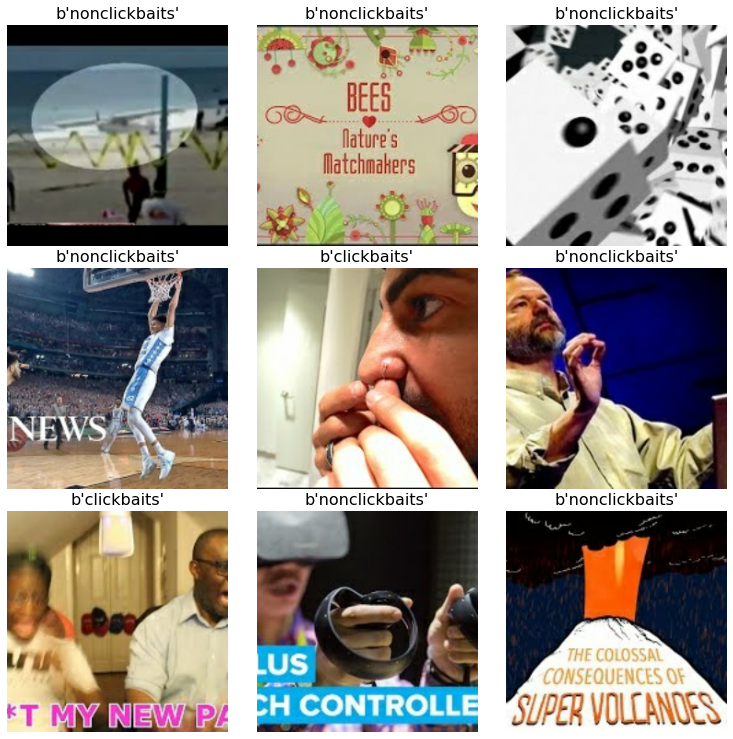

In [ ]:
display_train_ds = train_ds.take(1)
display_9_images_from_batched_dataset_old(display_train_ds, CLASSES)

#Data augmentation

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation",
)

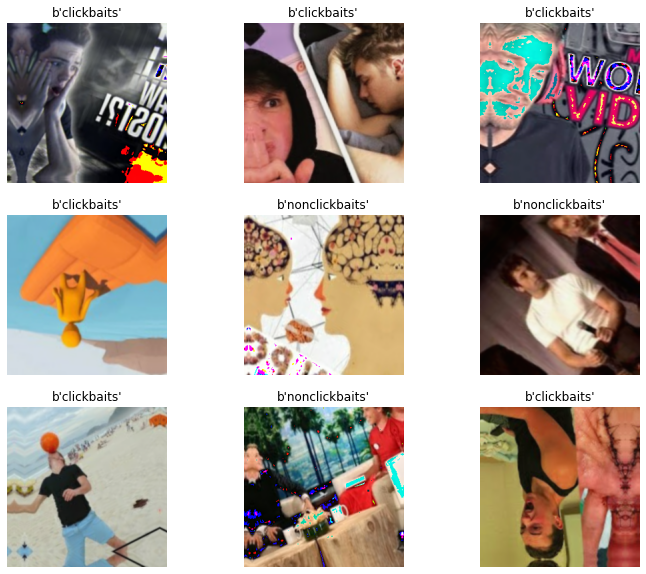

In [ ]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[i], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(CLASSES[label[i]]))
        plt.axis("off")

#Build model

In [14]:
model_builder = EffcientnetModelBuilder(IMG_SIZE=(IMG_SIZE, IMG_SIZE),
                                        weight='/content/drive/MyDrive/Colab Notebooks/efficientnetb1_notop.h5', 
                                        fine_tune=True,
                                        fine_tune_at=-10,
                                        weight_normalize=False,
                                        add_regularizer=False,
                                        )

effnet_b1_v2_model = model_builder.get_model()
effnet_b1_v2_model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 240, 240, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)              

#Training

In [15]:
callbacks = get_callbacks(efficientNet_B1_model_weight_finetuned_path)
 
init_lr = 1e-3
end_lr = 1e-6
power = 5.0  
decay_rate=0.90
epochs=20

num_train_steps = steps_per_epoch * epochs


lr_schedule_poly = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = init_lr,
    decay_steps=num_train_steps,
    end_learning_rate=end_lr,
    power=power,
)

lr_schedule_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr, decay_steps=num_train_steps, decay_rate=decay_rate, staircase=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_exp)


effnet_b1_v2_model, effnet_b1_v2_history = mh.compile_train_model(
                                                                      effnet_b1_v2_model,
                                                                      train_ds, 
                                                                      val_ds,
                                                                      steps_per_epoch=420,
                                                                      validation_steps=100,
                                                                      EPOCHS=epochs,
                                                                      LOSS=keras.losses.BinaryCrossentropy(),
                                                                      OPTIMIZER = optimizer,
                                                                      CALLBACKS = callbacks,
                                                                      save_model = True,
                                                                      model_save_path = efficientNet_B1_model_finetuned_path
                                                                  )

Epoch 1/20
420/420 [==============================] - 112s 150ms/step - loss: 0.5897 - tp: 4534.0000 - fp: 2246.0000 - tn: 4671.0000 - fn: 1989.0000 - accuracy: 0.6849 - precision: 0.6687 - recall: 0.6951 - auc: 0.7539 - prc: 0.7248 - val_loss: 0.4783 - val_tp: 1128.0000 - val_fp: 462.0000 - val_tn: 1310.0000 - val_fn: 300.0000 - val_accuracy: 0.7619 - val_precision: 0.7094 - val_recall: 0.7899 - val_auc: 0.8523 - val_prc: 0.8191

Epoch 00001: val_prc improved from -inf to 0.81911, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/efficientNet_B1_finetuned_weights.h5
Epoch 2/20
420/420 [==============================] - 62s 148ms/step - loss: 0.5080 - tp: 5051.0000 - fp: 1842.0000 - tn: 5014.0000 - fn: 1533.0000 - accuracy: 0.7489 - precision: 0.7328 - recall: 0.7672 - auc: 0.8300 - prc: 0.8133 - val_loss: 0.4841 - val_tp: 1082.0000 - val_fp: 393.0000 - val_tn: 1379.0000 - val_fn: 346.0000 - val_accuracy: 0.7691 - val_precision: 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Plot training history

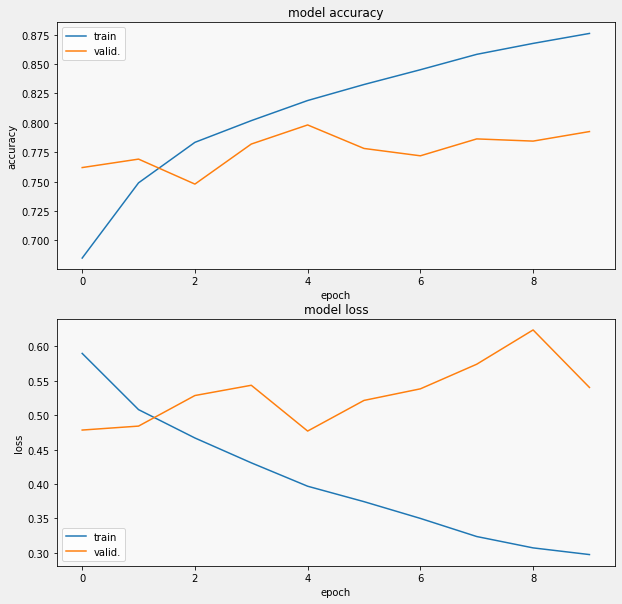

In [18]:
vh.display_training_curves(effnet_b1_v2_history.history['accuracy'], effnet_b1_v2_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(effnet_b1_v2_history.history['loss'], effnet_b1_v2_history.history['val_loss'], 'loss', 212)

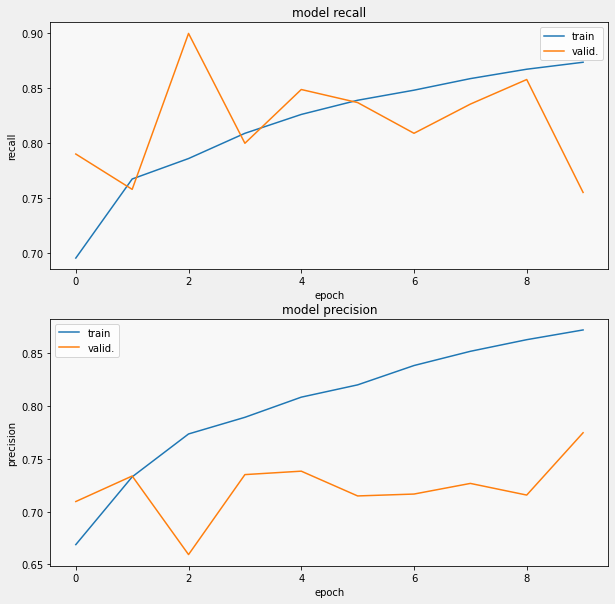

In [19]:
vh.display_training_curves(effnet_b1_v2_history.history['recall'], effnet_b1_v2_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(effnet_b1_v2_history.history['precision'], effnet_b1_v2_history.history['val_precision'], 'precision', 212)

#Model evaluation and Predictions

61/61 [==============================] - 9s 135ms/step - loss: 0.4653 - tp: 771.0000 - fp: 237.0000 - tn: 799.0000 - fn: 141.0000 - accuracy: 0.8060 - precision: 0.7649 - recall: 0.8454 - auc: 0.8890 - prc: 0.8694
loss :  0.46530014276504517
tp :  771.0
fp :  237.0
tn :  799.0
fn :  141.0
accuracy :  0.8059548139572144
precision :  0.7648809552192688
recall :  0.8453947305679321
auc :  0.8889685273170471
prc :  0.8693690896034241



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.825000
Precision: 0.797938
Recall: 0.846827
F1 score: 0.821656
ROC AUC: 0.825998
[[405  98]
 [ 70 387]]
Non clickbaits Detected (True Negatives):  405
Non-Clickbaits Detected as Clickbaits (False Positives):  98
Clickbaits Detected as Non-clickbaits (False Negatives):  70
Clickbaits Detected (True Positives):  387
Total Non-clickbaits:  503
Total Clickbaits:  457



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


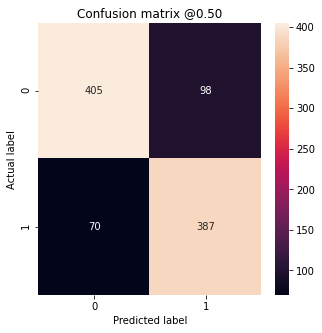

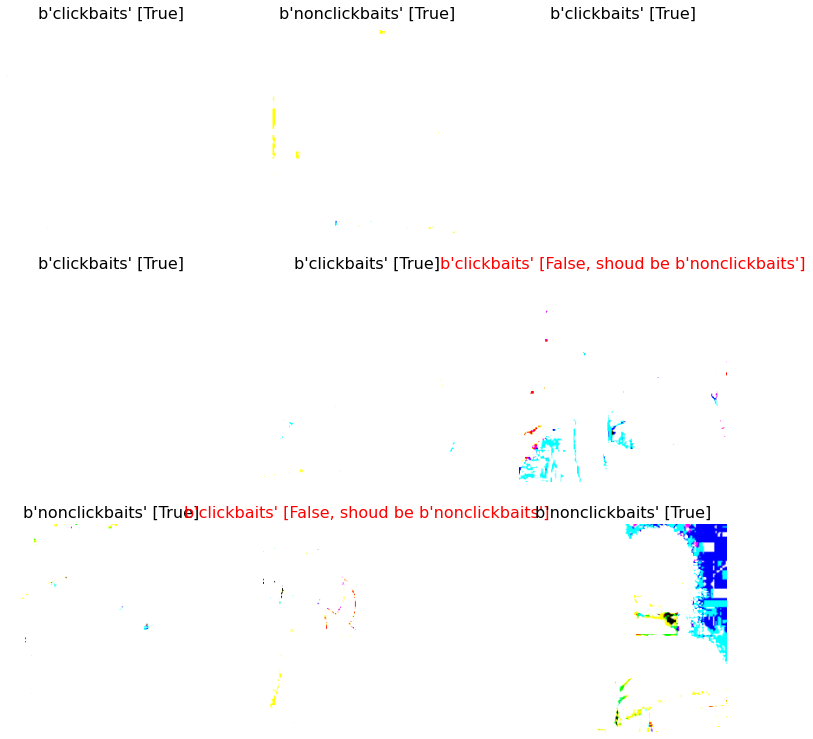

In [20]:
#saved_model_efficientNet_b1_v2 = keras.models.load_model(efficientNet_B1_model_finetuned_path)
results = effnet_b1_v2_model.evaluate(test_ds)

for name, value in zip(effnet_b1_v2_model.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(effnet_b1_v2_model, test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

#Benchmarking the model with Invid2.0 dataset

In [54]:
invid_tfrec_root = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

In [55]:
#instantiate read_data utility
read_data = read_tfrec_data(invid_tfrec_root,TARGET_SIZE=TARGET_SIZE,  VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=0, BATCH_SIZE=BATCH_SIZE)
benchmarking_filenames, _, _,_ = read_data.get_tfrec_files() 

Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


In [56]:
benchmark_ds = load_dataset(benchmarking_filenames)
benchmark_ds = benchmark_ds.map(_resize_img)
benchmark_ds = get_batched_dataset(benchmark_ds, train=False)


In [57]:
benchmark_ds.element_spec

(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [58]:
results = effnet_b1_v2_model.evaluate(benchmark_ds)


for name, value in zip(effnet_b1_v2_model.metrics_names, results):
  print(name, ': ', value)
print()



6/6 [==============================] - 1s 94ms/step - loss: 0.6106 - tp: 71.0000 - fp: 20.0000 - tn: 49.0000 - fn: 23.0000 - accuracy: 0.7362 - precision: 0.7802 - recall: 0.7553 - auc: 0.8044 - prc: 0.8587
loss :  0.6106442213058472
tp :  71.0
fp :  20.0
tn :  49.0
fn :  23.0
accuracy :  0.7361963391304016
precision :  0.7802197933197021
recall :  0.7553191781044006
auc :  0.8044250011444092
prc :  0.8587181568145752



Accuracy: 0.737500
Precision: 0.788889
Recall: 0.755319
F1 score: 0.771739
ROC AUC: 0.733720
[[47 19]
 [23 71]]

Non clickbaits Detected (True Negatives):  47
Non-Clickbaits Detected as Clickbaits (False Positives):  19
Clickbaits Detected as Non-clickbaits (False Negatives):  23
Clickbaits Detected (True Positives):  71
Total Non-clickbaits:  66
Total Clickbaits:  94


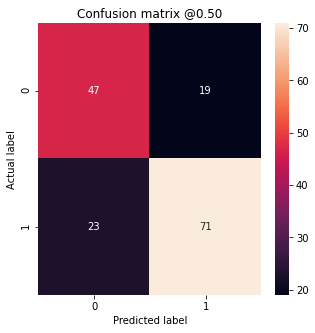

In [63]:
test_image, y_true, y_pred = predict_on_test(effnet_b1_v2_model,benchmark_ds,N=5)